# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

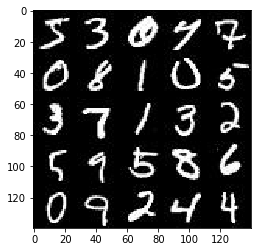

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

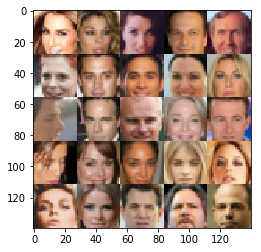

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/Kishor/miniconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_height, image_width, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [10]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits    
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha = 0.2 
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss 

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    b, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)    
    
    print_every = 10
    show_every = 100 
    losses = []
    n_images = 25
    steps = 0
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                sess.run(d_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                sess.run(g_opt,feed_dict={input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                
                
                if steps % print_every == 0:

                    # At the end of each epoch, get the losses and print them out                    
                    train_loss_d = d_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})
                    train_loss_g = g_loss.eval({input_real:batch_images, input_z:batch_z, input_lr:learning_rate})                    
                

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.6772... Generator Loss: 2.3430
Epoch 1/2... Discriminator Loss: 3.4288... Generator Loss: 0.0390
Epoch 1/2... Discriminator Loss: 2.3592... Generator Loss: 0.1112
Epoch 1/2... Discriminator Loss: 1.7848... Generator Loss: 0.2407
Epoch 1/2... Discriminator Loss: 1.5322... Generator Loss: 0.3889
Epoch 1/2... Discriminator Loss: 1.8873... Generator Loss: 0.2027
Epoch 1/2... Discriminator Loss: 1.8790... Generator Loss: 0.2064
Epoch 1/2... Discriminator Loss: 1.6510... Generator Loss: 0.2661
Epoch 1/2... Discriminator Loss: 1.2933... Generator Loss: 0.4620
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 0.4363


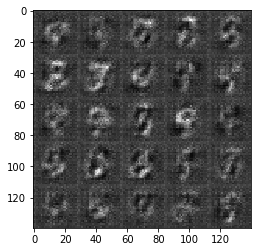

Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.3437
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.3388
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.3796
Epoch 1/2... Discriminator Loss: 1.6483... Generator Loss: 0.2519
Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 0.6252
Epoch 1/2... Discriminator Loss: 1.0529... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 2.2130
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 2.7799
Epoch 1/2... Discriminator Loss: 0.8952... Generator Loss: 1.6269
Epoch 1/2... Discriminator Loss: 0.9754... Generator Loss: 1.9322


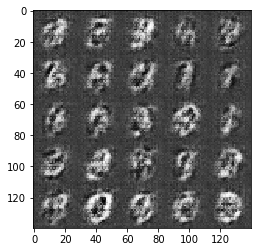

Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.5344
Epoch 1/2... Discriminator Loss: 0.7146... Generator Loss: 1.7365
Epoch 1/2... Discriminator Loss: 0.9441... Generator Loss: 2.4691
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.8933... Generator Loss: 0.7384
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 2.2064
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 1.6167
Epoch 1/2... Discriminator Loss: 0.9315... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 0.8092... Generator Loss: 1.3670


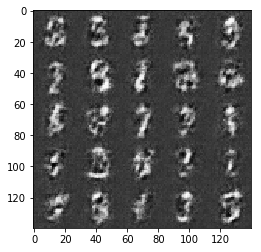

Epoch 1/2... Discriminator Loss: 0.6857... Generator Loss: 0.8682
Epoch 1/2... Discriminator Loss: 1.1566... Generator Loss: 0.4386
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.3777
Epoch 1/2... Discriminator Loss: 0.6895... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 1.2797
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 0.3329
Epoch 1/2... Discriminator Loss: 0.7174... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 1.2817
Epoch 1/2... Discriminator Loss: 0.4687... Generator Loss: 1.2641
Epoch 1/2... Discriminator Loss: 0.8928... Generator Loss: 0.6110


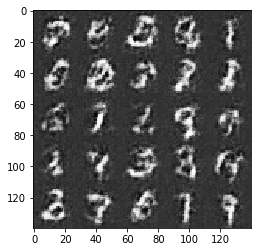

Epoch 1/2... Discriminator Loss: 2.3593... Generator Loss: 3.4104
Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.5246
Epoch 1/2... Discriminator Loss: 0.8606... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3442... Generator Loss: 0.3580
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 0.7494... Generator Loss: 0.8884
Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.5991
Epoch 1/2... Discriminator Loss: 0.7462... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.3547
Epoch 1/2... Discriminator Loss: 0.4349... Generator Loss: 1.2843


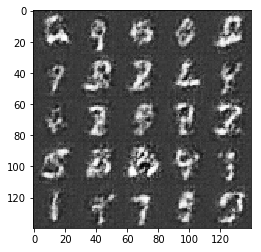

Epoch 1/2... Discriminator Loss: 0.7409... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 2.7561... Generator Loss: 4.7530
Epoch 1/2... Discriminator Loss: 0.9726... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 0.6974... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 0.3631... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.5763
Epoch 1/2... Discriminator Loss: 0.4451... Generator Loss: 1.2890
Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 1.3389
Epoch 1/2... Discriminator Loss: 2.4215... Generator Loss: 4.2591
Epoch 1/2... Discriminator Loss: 0.9455... Generator Loss: 0.8230


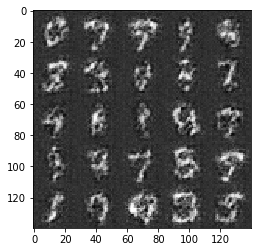

Epoch 1/2... Discriminator Loss: 1.1750... Generator Loss: 0.4455
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 0.8130
Epoch 1/2... Discriminator Loss: 0.8759... Generator Loss: 0.6597
Epoch 1/2... Discriminator Loss: 0.5858... Generator Loss: 0.9776
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 0.4432
Epoch 1/2... Discriminator Loss: 1.0306... Generator Loss: 0.5213
Epoch 1/2... Discriminator Loss: 0.6366... Generator Loss: 0.8994
Epoch 1/2... Discriminator Loss: 0.6001... Generator Loss: 0.9450
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 0.7293
Epoch 1/2... Discriminator Loss: 4.1816... Generator Loss: 0.0288


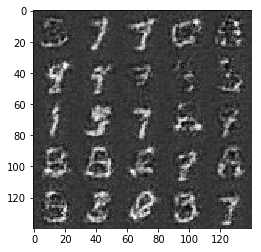

Epoch 1/2... Discriminator Loss: 1.6642... Generator Loss: 0.2419
Epoch 1/2... Discriminator Loss: 1.2844... Generator Loss: 0.6286
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 0.6942
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 1.2477
Epoch 1/2... Discriminator Loss: 0.3147... Generator Loss: 2.5463
Epoch 1/2... Discriminator Loss: 0.3053... Generator Loss: 1.7360
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.4845
Epoch 1/2... Discriminator Loss: 0.5971... Generator Loss: 0.9156
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 0.5223
Epoch 1/2... Discriminator Loss: 0.8727... Generator Loss: 0.6183


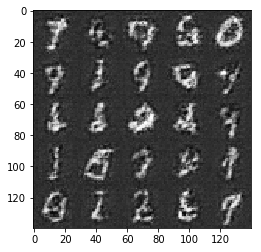

Epoch 1/2... Discriminator Loss: 0.5848... Generator Loss: 0.9286
Epoch 1/2... Discriminator Loss: 1.9588... Generator Loss: 0.1720
Epoch 1/2... Discriminator Loss: 1.7877... Generator Loss: 2.8605
Epoch 1/2... Discriminator Loss: 1.2674... Generator Loss: 1.6891
Epoch 1/2... Discriminator Loss: 0.8305... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 1.1379
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 0.7156
Epoch 1/2... Discriminator Loss: 0.7700... Generator Loss: 0.7737
Epoch 1/2... Discriminator Loss: 0.6227... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 0.2716... Generator Loss: 1.8377


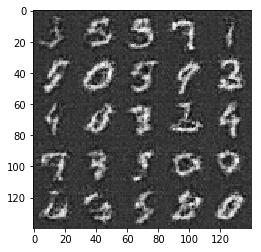

Epoch 1/2... Discriminator Loss: 0.3992... Generator Loss: 1.4553
Epoch 1/2... Discriminator Loss: 0.1337... Generator Loss: 3.0427
Epoch 1/2... Discriminator Loss: 1.5115... Generator Loss: 0.2880
Epoch 1/2... Discriminator Loss: 1.3794... Generator Loss: 1.7723
Epoch 1/2... Discriminator Loss: 1.1199... Generator Loss: 0.5676
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 0.6599
Epoch 1/2... Discriminator Loss: 0.8986... Generator Loss: 0.6419
Epoch 1/2... Discriminator Loss: 0.8992... Generator Loss: 1.0050
Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.1310
Epoch 1/2... Discriminator Loss: 0.9814... Generator Loss: 0.5678


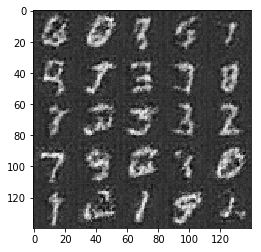

Epoch 1/2... Discriminator Loss: 0.8032... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 0.2409... Generator Loss: 1.9940
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 0.4896
Epoch 1/2... Discriminator Loss: 1.4671... Generator Loss: 2.7364
Epoch 1/2... Discriminator Loss: 0.4037... Generator Loss: 1.4035
Epoch 1/2... Discriminator Loss: 0.5850... Generator Loss: 0.9456
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 0.5252... Generator Loss: 1.0272
Epoch 1/2... Discriminator Loss: 0.2386... Generator Loss: 1.9115
Epoch 1/2... Discriminator Loss: 0.8237... Generator Loss: 0.7108


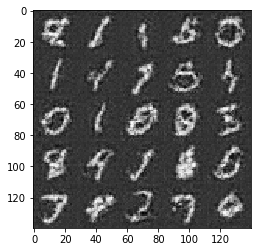

Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 0.8775
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 0.7603... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 0.7555... Generator Loss: 5.4665
Epoch 1/2... Discriminator Loss: 1.1309... Generator Loss: 0.5843
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 1.9502
Epoch 1/2... Discriminator Loss: 1.6359... Generator Loss: 4.0270
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 0.8265... Generator Loss: 0.6674


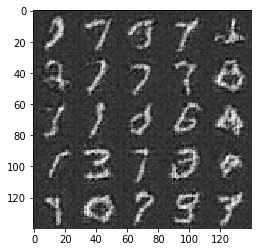

Epoch 1/2... Discriminator Loss: 0.8863... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 0.2766... Generator Loss: 1.8474
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 0.3458... Generator Loss: 1.4875
Epoch 1/2... Discriminator Loss: 1.6454... Generator Loss: 0.2838
Epoch 1/2... Discriminator Loss: 0.8529... Generator Loss: 2.7684
Epoch 1/2... Discriminator Loss: 0.2595... Generator Loss: 2.6774
Epoch 1/2... Discriminator Loss: 0.1042... Generator Loss: 2.9281
Epoch 1/2... Discriminator Loss: 0.0795... Generator Loss: 4.1977
Epoch 1/2... Discriminator Loss: 1.3473... Generator Loss: 0.3676


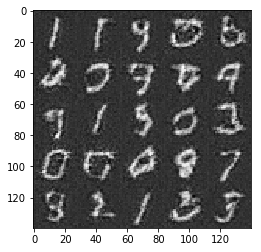

Epoch 1/2... Discriminator Loss: 0.1477... Generator Loss: 2.4263
Epoch 1/2... Discriminator Loss: 0.0778... Generator Loss: 3.8952
Epoch 1/2... Discriminator Loss: 0.3292... Generator Loss: 1.6368
Epoch 1/2... Discriminator Loss: 0.9535... Generator Loss: 0.5864
Epoch 1/2... Discriminator Loss: 1.5708... Generator Loss: 0.2705
Epoch 1/2... Discriminator Loss: 3.2012... Generator Loss: 0.0499
Epoch 1/2... Discriminator Loss: 1.5550... Generator Loss: 0.3051
Epoch 1/2... Discriminator Loss: 0.5440... Generator Loss: 1.5151
Epoch 1/2... Discriminator Loss: 0.6129... Generator Loss: 0.9971
Epoch 1/2... Discriminator Loss: 1.7657... Generator Loss: 0.2212


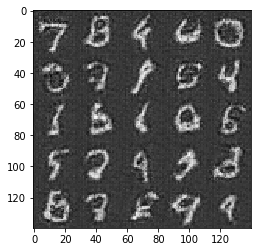

Epoch 1/2... Discriminator Loss: 0.1295... Generator Loss: 2.7923
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 1.8204
Epoch 1/2... Discriminator Loss: 0.9368... Generator Loss: 1.9844
Epoch 1/2... Discriminator Loss: 0.9619... Generator Loss: 1.9458
Epoch 1/2... Discriminator Loss: 0.7887... Generator Loss: 1.2762
Epoch 1/2... Discriminator Loss: 0.6380... Generator Loss: 1.5314
Epoch 1/2... Discriminator Loss: 0.8287... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.3666... Generator Loss: 0.3644
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.3313
Epoch 1/2... Discriminator Loss: 1.1926... Generator Loss: 0.4397


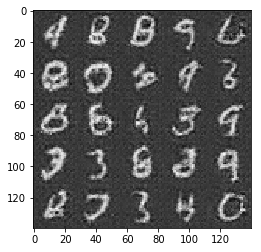

Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 3.1620
Epoch 1/2... Discriminator Loss: 0.5327... Generator Loss: 1.1164
Epoch 1/2... Discriminator Loss: 1.0588... Generator Loss: 0.4872
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.4579
Epoch 1/2... Discriminator Loss: 0.9534... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.5374... Generator Loss: 0.2989
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 0.4929... Generator Loss: 1.2048
Epoch 1/2... Discriminator Loss: 0.3508... Generator Loss: 1.5219
Epoch 1/2... Discriminator Loss: 1.0992... Generator Loss: 0.6006


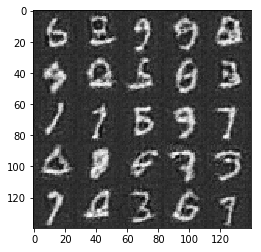

Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 0.5520... Generator Loss: 1.0194
Epoch 1/2... Discriminator Loss: 0.1105... Generator Loss: 2.8471
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 0.1379... Generator Loss: 2.4646
Epoch 1/2... Discriminator Loss: 0.7930... Generator Loss: 0.7163
Epoch 1/2... Discriminator Loss: 0.5400... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 2.4568... Generator Loss: 0.1155
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 0.8367


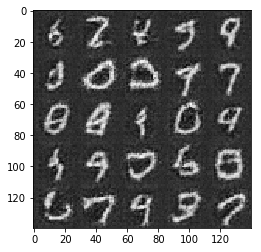

Epoch 1/2... Discriminator Loss: 2.7896... Generator Loss: 0.0992
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 2.2234
Epoch 1/2... Discriminator Loss: 0.5513... Generator Loss: 2.1389
Epoch 1/2... Discriminator Loss: 1.7106... Generator Loss: 3.1386
Epoch 1/2... Discriminator Loss: 0.6465... Generator Loss: 0.9562
Epoch 1/2... Discriminator Loss: 0.3111... Generator Loss: 2.0197
Epoch 1/2... Discriminator Loss: 0.3672... Generator Loss: 1.4408
Epoch 1/2... Discriminator Loss: 0.1679... Generator Loss: 2.2606
Epoch 1/2... Discriminator Loss: 0.6004... Generator Loss: 1.2055
Epoch 1/2... Discriminator Loss: 1.6211... Generator Loss: 0.3090


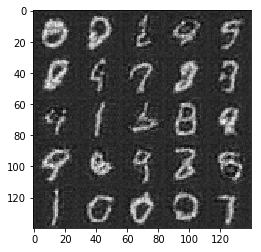

Epoch 1/2... Discriminator Loss: 0.3158... Generator Loss: 1.6427
Epoch 1/2... Discriminator Loss: 0.7779... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 3.2389
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.9239... Generator Loss: 0.2207
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.3698
Epoch 1/2... Discriminator Loss: 0.1696... Generator Loss: 2.2479
Epoch 2/2... Discriminator Loss: 0.3540... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 0.8457
Epoch 2/2... Discriminator Loss: 0.2755... Generator Loss: 1.8001


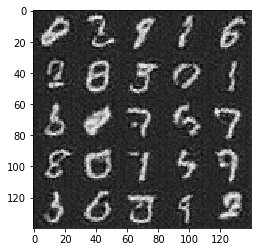

Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 1.1633
Epoch 2/2... Discriminator Loss: 0.0939... Generator Loss: 3.1335
Epoch 2/2... Discriminator Loss: 1.3120... Generator Loss: 0.4058
Epoch 2/2... Discriminator Loss: 0.4524... Generator Loss: 1.2287
Epoch 2/2... Discriminator Loss: 0.5485... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 0.5456... Generator Loss: 1.1095
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 0.0670... Generator Loss: 4.0433
Epoch 2/2... Discriminator Loss: 0.5136... Generator Loss: 1.3208
Epoch 2/2... Discriminator Loss: 0.2871... Generator Loss: 1.8474


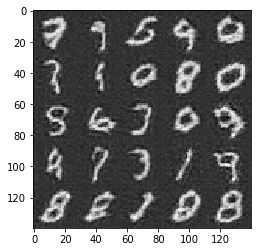

Epoch 2/2... Discriminator Loss: 0.5028... Generator Loss: 1.1752
Epoch 2/2... Discriminator Loss: 0.2294... Generator Loss: 1.8889
Epoch 2/2... Discriminator Loss: 0.5707... Generator Loss: 1.0486
Epoch 2/2... Discriminator Loss: 0.1114... Generator Loss: 2.7276
Epoch 2/2... Discriminator Loss: 0.0544... Generator Loss: 4.4937
Epoch 2/2... Discriminator Loss: 0.2146... Generator Loss: 2.0130
Epoch 2/2... Discriminator Loss: 0.3421... Generator Loss: 1.5145
Epoch 2/2... Discriminator Loss: 1.8770... Generator Loss: 0.1887
Epoch 2/2... Discriminator Loss: 0.3042... Generator Loss: 1.6210
Epoch 2/2... Discriminator Loss: 0.4584... Generator Loss: 1.1152


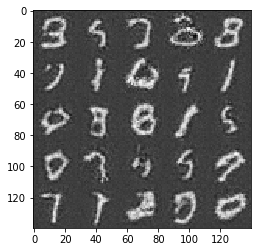

Epoch 2/2... Discriminator Loss: 0.4254... Generator Loss: 1.2621
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.4257
Epoch 2/2... Discriminator Loss: 0.3026... Generator Loss: 1.7699
Epoch 2/2... Discriminator Loss: 0.3175... Generator Loss: 2.2952
Epoch 2/2... Discriminator Loss: 0.1378... Generator Loss: 2.7188
Epoch 2/2... Discriminator Loss: 0.1878... Generator Loss: 2.2079
Epoch 2/2... Discriminator Loss: 0.9143... Generator Loss: 0.6850
Epoch 2/2... Discriminator Loss: 1.5438... Generator Loss: 0.3353
Epoch 2/2... Discriminator Loss: 0.4079... Generator Loss: 1.8316
Epoch 2/2... Discriminator Loss: 0.5543... Generator Loss: 2.9364


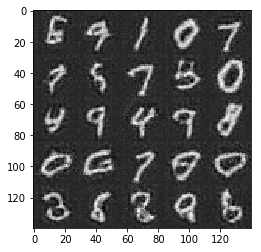

Epoch 2/2... Discriminator Loss: 2.8561... Generator Loss: 6.0308
Epoch 2/2... Discriminator Loss: 0.4164... Generator Loss: 1.3377
Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 0.6718... Generator Loss: 2.1469
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 1.8041
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 1.5035
Epoch 2/2... Discriminator Loss: 2.3933... Generator Loss: 0.1244
Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 2.8426
Epoch 2/2... Discriminator Loss: 0.6439... Generator Loss: 3.0159
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.4375


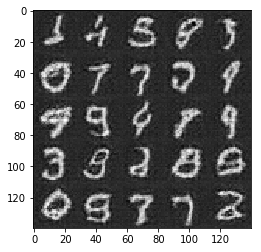

Epoch 2/2... Discriminator Loss: 0.1917... Generator Loss: 3.8536
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.4220
Epoch 2/2... Discriminator Loss: 2.0844... Generator Loss: 0.1683
Epoch 2/2... Discriminator Loss: 1.8472... Generator Loss: 0.2178
Epoch 2/2... Discriminator Loss: 0.1601... Generator Loss: 2.1832
Epoch 2/2... Discriminator Loss: 0.4543... Generator Loss: 2.9186
Epoch 2/2... Discriminator Loss: 0.5609... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 0.4213... Generator Loss: 3.0231
Epoch 2/2... Discriminator Loss: 0.4532... Generator Loss: 1.2993
Epoch 2/2... Discriminator Loss: 2.5600... Generator Loss: 0.1184


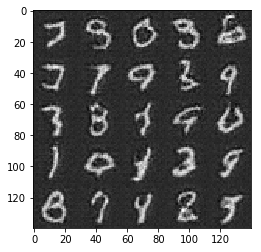

Epoch 2/2... Discriminator Loss: 0.7675... Generator Loss: 0.9421
Epoch 2/2... Discriminator Loss: 0.6205... Generator Loss: 0.9903
Epoch 2/2... Discriminator Loss: 0.1481... Generator Loss: 2.4728
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 1.3546
Epoch 2/2... Discriminator Loss: 1.6156... Generator Loss: 0.2920
Epoch 2/2... Discriminator Loss: 0.7117... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 0.2460... Generator Loss: 2.1068
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.3836
Epoch 2/2... Discriminator Loss: 0.1152... Generator Loss: 2.8126
Epoch 2/2... Discriminator Loss: 0.3302... Generator Loss: 1.5904


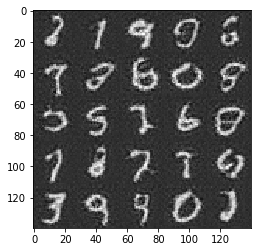

Epoch 2/2... Discriminator Loss: 0.1450... Generator Loss: 2.8629
Epoch 2/2... Discriminator Loss: 0.0333... Generator Loss: 4.3928
Epoch 2/2... Discriminator Loss: 1.1738... Generator Loss: 0.4761
Epoch 2/2... Discriminator Loss: 1.6300... Generator Loss: 0.2550
Epoch 2/2... Discriminator Loss: 0.0482... Generator Loss: 4.9993
Epoch 2/2... Discriminator Loss: 1.2682... Generator Loss: 0.4437
Epoch 2/2... Discriminator Loss: 0.0649... Generator Loss: 3.3366
Epoch 2/2... Discriminator Loss: 0.0717... Generator Loss: 4.4787
Epoch 2/2... Discriminator Loss: 0.4716... Generator Loss: 1.1634
Epoch 2/2... Discriminator Loss: 0.5126... Generator Loss: 1.0864


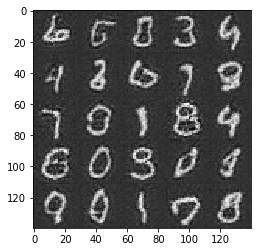

Epoch 2/2... Discriminator Loss: 0.4991... Generator Loss: 1.1824
Epoch 2/2... Discriminator Loss: 0.5691... Generator Loss: 1.0176
Epoch 2/2... Discriminator Loss: 0.3247... Generator Loss: 1.6032
Epoch 2/2... Discriminator Loss: 0.7589... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 1.8281
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 1.3417
Epoch 2/2... Discriminator Loss: 1.7863... Generator Loss: 0.2380
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 0.9453
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 0.6842
Epoch 2/2... Discriminator Loss: 0.7387... Generator Loss: 0.8050


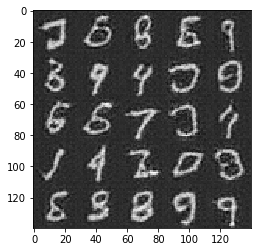

Epoch 2/2... Discriminator Loss: 0.2546... Generator Loss: 1.9399
Epoch 2/2... Discriminator Loss: 0.5795... Generator Loss: 1.0805
Epoch 2/2... Discriminator Loss: 0.7172... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 1.7190... Generator Loss: 0.5360
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.4601
Epoch 2/2... Discriminator Loss: 0.3290... Generator Loss: 1.6059
Epoch 2/2... Discriminator Loss: 1.1126... Generator Loss: 0.4761
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 0.7760
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 0.3572
Epoch 2/2... Discriminator Loss: 0.3687... Generator Loss: 1.3937


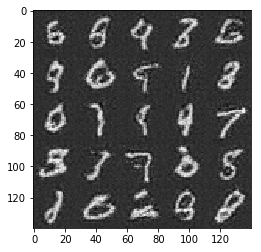

Epoch 2/2... Discriminator Loss: 1.3189... Generator Loss: 4.4487
Epoch 2/2... Discriminator Loss: 0.4865... Generator Loss: 1.3935
Epoch 2/2... Discriminator Loss: 0.3624... Generator Loss: 1.7531
Epoch 2/2... Discriminator Loss: 0.6044... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 1.2858... Generator Loss: 0.4362
Epoch 2/2... Discriminator Loss: 0.8340... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.4681... Generator Loss: 1.2611
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 1.6079
Epoch 2/2... Discriminator Loss: 0.4670... Generator Loss: 1.2052
Epoch 2/2... Discriminator Loss: 0.2103... Generator Loss: 2.3718


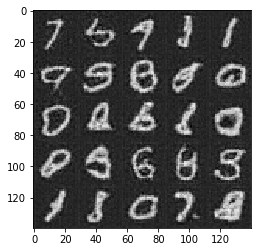

Epoch 2/2... Discriminator Loss: 1.1760... Generator Loss: 0.4783
Epoch 2/2... Discriminator Loss: 0.8994... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 0.1890... Generator Loss: 2.0723
Epoch 2/2... Discriminator Loss: 0.2799... Generator Loss: 1.7824
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 1.2410
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.7152... Generator Loss: 0.8484
Epoch 2/2... Discriminator Loss: 0.4572... Generator Loss: 1.3034
Epoch 2/2... Discriminator Loss: 0.0352... Generator Loss: 4.7275
Epoch 2/2... Discriminator Loss: 0.6262... Generator Loss: 0.9184


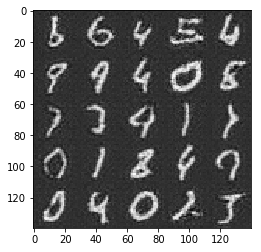

Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.8437... Generator Loss: 0.6887
Epoch 2/2... Discriminator Loss: 0.8272... Generator Loss: 0.9431
Epoch 2/2... Discriminator Loss: 0.5425... Generator Loss: 1.0933
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 0.7871... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.9404... Generator Loss: 0.6650
Epoch 2/2... Discriminator Loss: 0.2551... Generator Loss: 1.9515
Epoch 2/2... Discriminator Loss: 1.4303... Generator Loss: 0.3483
Epoch 2/2... Discriminator Loss: 1.4006... Generator Loss: 0.3935


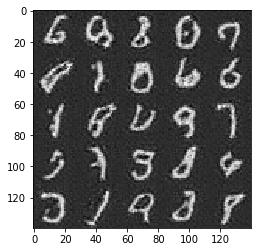

Epoch 2/2... Discriminator Loss: 2.0881... Generator Loss: 6.2129
Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.1547
Epoch 2/2... Discriminator Loss: 0.5215... Generator Loss: 1.2924
Epoch 2/2... Discriminator Loss: 0.7647... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.5879
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 0.8250
Epoch 2/2... Discriminator Loss: 7.8727... Generator Loss: 7.0670
Epoch 2/2... Discriminator Loss: 0.5826... Generator Loss: 1.3759
Epoch 2/2... Discriminator Loss: 0.4487... Generator Loss: 1.4614


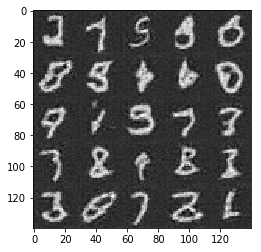

Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 0.8251
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 0.6187... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 0.7209... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.1582... Generator Loss: 0.5265
Epoch 2/2... Discriminator Loss: 0.3599... Generator Loss: 1.3545
Epoch 2/2... Discriminator Loss: 1.4030... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 0.7457... Generator Loss: 0.8074
Epoch 2/2... Discriminator Loss: 0.3034... Generator Loss: 1.6060
Epoch 2/2... Discriminator Loss: 1.4543... Generator Loss: 0.3732


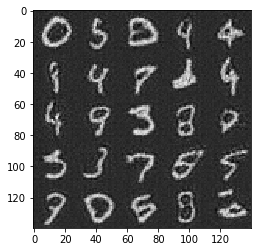

Epoch 2/2... Discriminator Loss: 0.1673... Generator Loss: 2.1819
Epoch 2/2... Discriminator Loss: 0.3759... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 0.2108... Generator Loss: 1.9962
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.4034
Epoch 2/2... Discriminator Loss: 0.8071... Generator Loss: 2.8054
Epoch 2/2... Discriminator Loss: 0.4921... Generator Loss: 1.2950
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.5790
Epoch 2/2... Discriminator Loss: 1.0185... Generator Loss: 0.5802
Epoch 2/2... Discriminator Loss: 0.8835... Generator Loss: 0.7664
Epoch 2/2... Discriminator Loss: 1.3218... Generator Loss: 0.3757


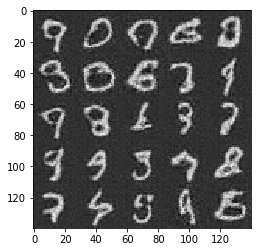

Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 0.7306
Epoch 2/2... Discriminator Loss: 1.4815... Generator Loss: 0.3477
Epoch 2/2... Discriminator Loss: 0.1919... Generator Loss: 2.2025
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.4495
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 0.6572
Epoch 2/2... Discriminator Loss: 0.3607... Generator Loss: 1.4661
Epoch 2/2... Discriminator Loss: 0.0870... Generator Loss: 3.3567
Epoch 2/2... Discriminator Loss: 0.6147... Generator Loss: 0.9734
Epoch 2/2... Discriminator Loss: 0.0428... Generator Loss: 3.9907
Epoch 2/2... Discriminator Loss: 0.1984... Generator Loss: 1.9461


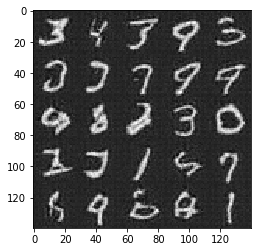

Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.5341
Epoch 2/2... Discriminator Loss: 0.2380... Generator Loss: 1.9059
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 0.7167
Epoch 2/2... Discriminator Loss: 0.3087... Generator Loss: 1.5490
Epoch 2/2... Discriminator Loss: 0.0301... Generator Loss: 4.2798
Epoch 2/2... Discriminator Loss: 0.9958... Generator Loss: 0.6034
Epoch 2/2... Discriminator Loss: 2.6246... Generator Loss: 5.4218
Epoch 2/2... Discriminator Loss: 0.3635... Generator Loss: 1.4868
Epoch 2/2... Discriminator Loss: 0.3194... Generator Loss: 2.0128
Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.0188


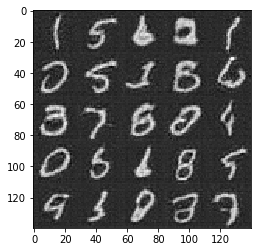

Epoch 2/2... Discriminator Loss: 0.7998... Generator Loss: 0.7149
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.3648
Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.5134
Epoch 2/2... Discriminator Loss: 1.7275... Generator Loss: 0.2512
Epoch 2/2... Discriminator Loss: 0.4206... Generator Loss: 1.3111
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 1.4539
Epoch 2/2... Discriminator Loss: 0.5146... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.4720... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 0.4642... Generator Loss: 1.2123
Epoch 2/2... Discriminator Loss: 0.1448... Generator Loss: 2.5983


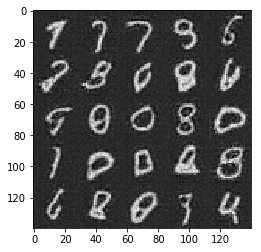

Epoch 2/2... Discriminator Loss: 0.2781... Generator Loss: 1.5896
Epoch 2/2... Discriminator Loss: 0.9386... Generator Loss: 0.5991
Epoch 2/2... Discriminator Loss: 0.1475... Generator Loss: 2.3169
Epoch 2/2... Discriminator Loss: 0.5436... Generator Loss: 1.1271
Epoch 2/2... Discriminator Loss: 0.5440... Generator Loss: 1.0749


NameError: name 'saver' is not defined

In [36]:
batch_size = 32
z_dim = 32
learning_rate = 0.0002
beta1 = 0.2

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.